In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append("./moabsim-journey")

from pyrr import matrix33, vector
from moab_model import MoabModel as MoabModelOld
from moab_model import clamp


class MoabSimOld:
    def __init__(self, config):
        self.config = config
        self.model = MoabModelOld()
        self._episode_count = 0
        self.model.reset()

        self.model.accel_param = lambda q, dest, vel, acc, max_vel, delta_t: (dest, vel)

    # callbacks
    def halted(self) -> bool:
        return self.model.halted()

    def get_interface(self):
        return None

    def get_state(self):
        return self.model.state()

    def _set_velocity_for_speed_and_direction(self, speed: float, direction: float):
        # get the heading
        dx = self.model.target_x - self.model.ball.x
        dy = self.model.target_y - self.model.ball.y

        # direction is meaningless if we're already at the target
        if (dx != 0) or (dy != 0):

            # set the magnitude
            vel = vector.set_length([dx, dy, 0.0], speed)

            # rotate by direction around Z-axis at ball position
            rot = matrix33.create_from_axis_rotation([0.0, 0.0, 1.0], direction)
            vel = matrix33.apply_to_vector(rot, vel)

            # unpack into ball velocity
            self.model.ball_vel.x = vel[0]
            self.model.ball_vel.y = vel[1]
            self.model.ball_vel.z = vel[2]

    def episode_start(self, config) -> None:
        # return to known good state to avoid accidental episode-episode dependencies
        self.model.reset()

        # initial control state. these are all [-1..1] unitless
        self.model.roll = config.get("initial_roll", self.model.roll)
        self.model.pitch = config.get("initial_pitch", self.model.pitch)

        self.model.height_z = config.get("initial_height_z", self.model.height_z)

        # constants, SI units.
        self.model.time_delta = config.get("time_delta", self.model.time_delta)
        self.model.jitter = config.get("jitter", self.model.jitter)
        self.model.gravity = config.get("gravity", self.model.gravity)
        self.model.plate_theta_vel_limit = config.get(
            "plate_theta_vel_limit", self.model.plate_theta_vel_limit
        )
        self.model.plate_theta_acc = config.get(
            "plate_theta_acc", self.model.plate_theta_acc
        )
        self.model.plate_theta_limit = config.get(
            "plate_theta_limit", self.model.plate_theta_limit
        )
        self.model.plate_z_limit = config.get("plate_z_limit", self.model.plate_z_limit)

        self.model.ball_mass = config.get("ball_mass", self.model.ball_mass)
        self.model.ball_radius = config.get("ball_radius", self.model.ball_radius)
        self.model.ball_shell = config.get("ball_shell", self.model.ball_shell)

        self.model.obstacle_radius = config.get(
            "obstacle_radius", self.model.obstacle_radius
        )
        self.model.obstacle_x = config.get("obstacle_x", self.model.obstacle_x)
        self.model.obstacle_y = config.get("obstacle_y", self.model.obstacle_y)

        # a target position the AI can try and move the ball to
        self.model.target_x = config.get("target_x", self.model.target_x)
        self.model.target_y = config.get("target_y", self.model.target_y)

        # observation config
        self.model.ball_noise = config.get("ball_noise", self.model.ball_noise)
        self.model.plate_noise = config.get("plate_noise", self.model.plate_noise)

        # now we can update the initial plate metrics from the constants and the controls
        self.model.update_plate(plate_reset=True)

        # initial ball state after updating plate
        self.model.set_initial_ball(
            config.get("initial_x", self.model.ball.x),
            config.get("initial_y", self.model.ball.y),
            config.get("initial_z", self.model.ball.z),
        )

        # velocity set as a vector
        self.model.ball_vel.x = config.get("initial_vel_x", self.model.ball_vel.x)
        self.model.ball_vel.y = config.get("initial_vel_y", self.model.ball_vel.y)
        self.model.ball_vel.z = config.get("initial_vel_z", self.model.ball_vel.z)

        # velocity set as a speed/direction towards target
        initial_speed = config.get("initial_speed", None)
        initial_direction = config.get("initial_direction", None)
        if initial_speed is not None and initial_direction is not None:
            self._set_velocity_for_speed_and_direction(initial_speed, initial_direction)

        # new episode, iteration count reset
        self.iteration_count = 0
        self._episode_count += 1

    def episode_step(self, action):
        # use new syntax or fall back to old parameter names
        self.model.roll = action.get("input_roll", self.model.roll)
        self.model.pitch = action.get("input_pitch", self.model.pitch)

        # clamp inputs to legal ranges
        # self.model.roll = clamp(self.model.roll, -1.0, 1.0)
        # self.model.pitch = clamp(self.model.pitch, -1.0, 1.0)

        self.model.height_z = clamp(
            action.get("input_height_z", self.model.height_z), -1.0, 1.0
        )

        self.model.step()

        self.iteration_count += 1

    def episode_finish(self, reason: str):
        pass


# Remove the path again
sys.path = sys.path[:-1]

In [3]:
sys.path.append("./moabsim-py")

from moab_sim import MoabSim as MoabSimNew

# Remove the path again
sys.path = sys.path[:-1]

In [4]:
sim_new = MoabSimNew()
sim_new.reset()

array([-0.01309601,  0.00475416,  0.20589712,  0.7813396 ], dtype=float32)

In [5]:
sim_new.state

array([-0.01309601,  0.00475416,  0.20589712,  0.7813396 ], dtype=float32)

In [6]:
sim_new.plate_angles

array([0., 0.], dtype=float32)

In [7]:
# for k, v in n.params.items():
#     print(k, v())

In [8]:
init_pitch, init_roll = sim_new.plate_angles
init_x, init_y, init_x_vel, init_y_vel = sim_new.state
config = {
    "initial_pitch": init_pitch,
    "initial_roll": init_roll,
    "initial_height_z": 0,
    "time_delta": sim_new.params["dt"](),
    "jitter": 0,
    "gravity": sim_new.params["gravity"](),
    "plate_theta_vel_limit": 0,
    "plate_theta_acc": 0,
    "plate_theta_limit": 0,
    "plate_z_limit": 0,
    "ball_mass": sim_new.params["ball_mass"](),
    "ball_radius": sim_new.params["ball_radius"](),
    "ball_shell": sim_new.params["ball_shell"](),
    "obstacle_radius": 0,
    "obstacle_x": 0,
    "obstacle_y": 0,
    "target_x": 0,
    "target_y": 0,
    "ball_noise": 0,
    "plate_noise": 0,
    "initial_x": init_x,
    "initial_y": init_y,
    "initial_z": 0,
    "initial_vel_x": init_x_vel,
    "initial_vel_y": init_y_vel,
    "initial_vel_z": 0,
}

sim_old = MoabSimOld(config)
sim_old.episode_start(config)

In [9]:
# # dir(o.model)
# for el in dir(sim_old.model):
#     if len(el) >= 2 and el[:2] == "__":
#         pass
#     else:
#         print(el, sim_old.model.__getattribute__(el))

In [10]:
n = 1000
hist_old = np.zeros((n, 6))  # x, y, x_vel, y_vel, action_pitch, action_roll

controller = pid_controller()
x, y, x_vel, y_vel = init_x, init_y, init_x_vel, init_y_vel

for i in range(n):
    pitch, roll = controller(x, y, x_vel, y_vel)

    sim_old.episode_step({"input_pitch": pitch, "input_roll": roll})
    state_dict = sim_old.get_state()
    x, y = state_dict["ball_x"], state_dict["ball_y"]
    x_vel, y_vel = state_dict["ball_vel_x"], state_dict["ball_vel_y"]

    hist_old[i, :] = x, y, x_vel, y_vel, pitch, roll

NameError: name 'pid_controller' is not defined

In [11]:
# state_dict
hist_old

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [12]:
hist_new = np.zeros((n, 6))  # x, y, x_vel, y_vel, action_pitch, action_roll

controller = pid_controller()
x, y, x_vel, y_vel = init_x, init_y, init_x_vel, init_y_vel

for i in range(n):
    pitch, roll = controller(x, y, x_vel, y_vel)

    x, y, x_vel, y_vel = sim_new.step([pitch, roll])  # actions_rand[i, :])
    hist_new[i, :] = x, y, x_vel, y_vel, pitch, roll

NameError: name 'pid_controller' is not defined

In [13]:
hist_new

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

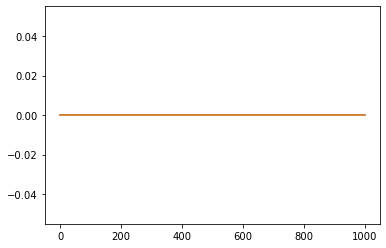

In [14]:
plt.plot(np.arange(n), hist_old[:, 0])
plt.plot(np.arange(n), hist_new[:, 0])

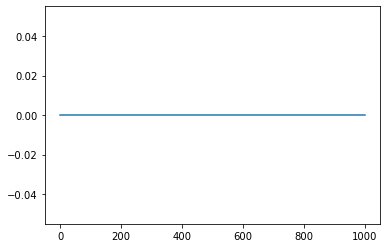

In [15]:
# plt.plot(np.arange(n), hist_old[:, 1])
plt.plot(np.arange(n), hist_new[:, 1])

In [16]:
init_pitch, init_roll = sim_new.plate_angles
init_x, init_y, init_x_vel, init_y_vel = sim_new.state
config = {
    "initial_pitch": init_pitch,
    "initial_roll": init_roll,
    "initial_height_z": 0,
    "time_delta": sim_new.params["dt"](),
    "jitter": 0,
    "gravity": sim_new.params["gravity"](),
    "plate_theta_vel_limit": 0,
    "plate_theta_acc": 0,
    "plate_theta_limit": np.radians(22),
    "plate_z_limit": 0,
    "ball_mass": sim_new.params["ball_mass"](),
    "ball_radius": sim_new.params["ball_radius"](),
    "ball_shell": sim_new.params["ball_shell"](),
    "obstacle_radius": 0,
    "obstacle_x": 0,
    "obstacle_y": 0,
    "target_x": 0,
    "target_y": 0,
    "ball_noise": 0,
    "plate_noise": 0,
    "initial_x": init_x,
    "initial_y": init_y,
    "initial_z": 0,
    "initial_vel_x": init_x_vel,
    "initial_vel_y": init_y_vel,
    "initial_vel_z": 0,
}

sim_old = MoabSimOld(config)
sim_old.episode_start(config)
init_pitch, init_roll, init_y

(0.0, 0.0, 0.0047541587)

In [17]:
print("pitch", sim_old.model.pitch)
print("roll", sim_old.model.roll)
print("plate_theta_x", sim_old.model.plate_theta_x)
print("plate_theta_y", sim_old.model.plate_theta_y)
print("plate_theta_vel_x", sim_old.model.plate_theta_vel_x)
print("plate_theta_vel_y", sim_old.model.plate_theta_vel_y)

pitch 0.0
roll 0.0
plate_theta_x 0.0
plate_theta_y 0.0
plate_theta_vel_x 0.0
plate_theta_vel_y 0.0


In [18]:
init_pitch, init_roll
init_x, init_y, init_x_vel, init_y_vel

(-0.013096011, 0.0047541587, 0.20589712, 0.7813396)

In [19]:
sim_old.episode_step({"input_pitch": 0, "input_roll": 0})
state_dict = sim_old.get_state()
# print(json.dumps(state_dict, indent=2))

x, y = state_dict["ball_x"], state_dict["ball_y"]
x_vel, y_vel = state_dict["ball_vel_x"], state_dict["ball_vel_y"]
print(f"x={x:.6f}, y={y:.6f}, x_vel={x_vel:.6f}, y_vel={y_vel:.6f}")

x=-0.006240, y=0.030773, x_vel=0.205897, y_vel=0.781340


In [20]:
pitch = np.random.uniform(-1, 1)
roll = np.random.uniform(-1, 1)

print(f"pitch={pitch:.6f}, roll={roll:.6f}")
print(f"prev -- x={x:.6f}, y={y:.6f}, x_vel={x_vel:.6f}, y_vel={y_vel:.6f}\n")

sim_old.episode_step({"input_pitch": pitch, "input_roll": roll})
state_dict = sim_old.get_state()
x_old, y_old = state_dict["ball_x"], state_dict["ball_y"]
x_vel_old, y_vel_old = state_dict["ball_vel_x"], state_dict["ball_vel_y"]
print(
    f"old -- x={x_old:.6f}, y={y_old:.6f}, x_vel={x_vel_old:.6f}, y_vel={y_vel_old:.6f}"
)


x_new, y_new, x_vel_new, y_vel_new = moab_model_new(
    state=np.array([x, y, x_vel, y_vel]),
    action=np.array([-pitch, -roll]),
    dt=state_dict["time_delta"],
    jitter=state_dict["jitter"],
    gravity=state_dict["gravity"],
    ball_radius=state_dict["ball_radius"],
    ball_shell=state_dict["ball_shell"],
)
print(
    f"new -- x={x_new:.6f}, y={y_new:.6f}, x_vel={x_vel_new:.6f}, y_vel={y_vel_new:.6f}"
)

pitch=-0.857282, roll=0.024231
prev -- x=-0.006240, y=0.030773, x_vel=0.205897, y_vel=0.781340

old -- x=0.000674, y=0.057878, x_vel=0.209332, y_vel=0.846596


NameError: name 'moab_model_new' is not defined

In [21]:
def moab_model_new(
    state: np.ndarray,
    action: np.ndarray,
    dt=1 / 30,
    jitter=0,
    gravity=9.81,
    ball_radius=0.02,
    ball_shell=0.0002,
    **kwargs
) -> np.ndarray:
    action = np.asarray(action) * np.radians(22)
    # fmt: off
    r = ball_radius
    h = ball_radius - ball_shell  # hollow radius
    dt += np.random.uniform(-jitter, jitter)  # add jitter to the simulation timesteps

    # Ball intertia for a hollow sphere is:
    # I = (2 / 5) * m * ((r**5 - h**5) / (r**3 - h**3))
    # Equations for acceleration on a plate at rest
    # a = (theta * m * g) / (m + (I / r**2))
    # Combine the two to get the acceleration divided by theta
    acc_div_theta = gravity / (1 + (2 / 5) * ((r**5 - h**5) / (r**3 - h**3)) / (r**2))

    A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    B = np.array([
        [(1 / 2) * dt**2 * acc_div_theta, 0],
        [0, (1 / 2) * dt**2 * acc_div_theta],
        [dt * acc_div_theta, 0],
        [0, dt * acc_div_theta]
    ])
    # fmt:on
    next_state = A @ state + B @ action  # x_t+1 = Ax_t + Bu_t
    return next_state

In [22]:
def pid_controller(Kp=0.155, Ki=0.00103, Kd=0.930, **kwargs):
    sum_x, sum_y = 0, 0

    def next_action(x, y, vel_x, vel_y):
        nonlocal sum_x, sum_y
        sum_x += x
        sum_y += y

        action_x = Kp * x + Ki * sum_x + Kd * vel_x
        action_y = Kp * y + Ki * sum_y + Kd * vel_y
        action = np.array([-action_x, -action_y])

        return action  # np.clip(action, -1, 1)
        # pitch, roll = np.radians(action) # np.clip(action, -22, 22))
        # return pitch, roll

    return next_action

In [23]:
sys.path.append("./moabsim-journey")

from moab_model import MoabModel


def instant_accel_param(q, dest, vel, acc, max_vel, delta_t):
    return (dest, vel)


# Remove the path again
sys.path = sys.path[:-1]

In [24]:
mm_old = MoabModel()
mm_old.accel_param = instant_accel_param
mm_old.reset()

[-0.50589284  0.38425516 -1.64351823 -0.3851933  -0.18944095 -0.72738761]
[-1.44259810e-12  1.84069703e-13  4.79078240e-13 -7.66290934e-14
 -1.89440953e-01 -7.27387606e-01]

[-0.55865047  0.37179138 -1.52193955 -0.36263341  1.6074199   0.29826954]
[-0.58026887  0.36525059 -1.66208341 -0.45945402  1.63627692  0.37030219]


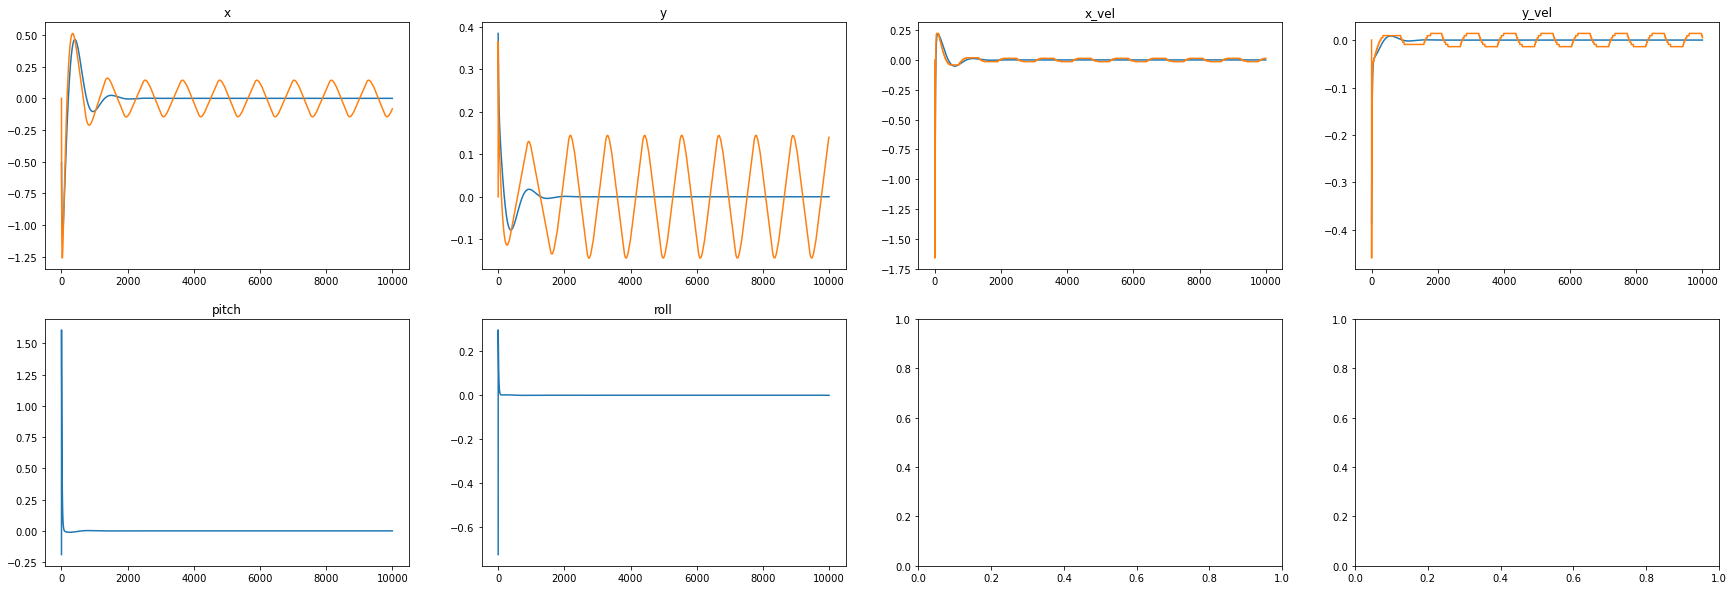

In [29]:
# New thingyyyyy
n = 10000
state_hist = np.zeros((n, 6))
state = np.concatenate([np.random.randn(2) * 0.1125, np.random.randn(2)]) * 4

controller = pid_controller()
x, y, x_vel, y_vel = init_x, init_y, init_x_vel, init_y_vel

for i in range(n):
    pitch, roll = controller(x, y, x_vel, y_vel)

    x, y, x_vel, y_vel = state = moab_model_new(state, [pitch, roll])
    state_hist[i, :] = x, y, x_vel, y_vel, pitch, roll


#
#
#
# Old thingy

state_hist_old = np.zeros((n, 6))
state = state_hist[0, :]

mm_old.ball[:2] = state[:2]
mm_old.ball_vel[:2] = state[2:4]
pitch, roll = state[4:6]
# print(mm_old.ball, mm_old.ball_vel, mm_old.pitch, mm_old.roll)

controller = pid_controller()

for i in range(n):
    state_hist_old[i, :] = x, y, x_vel, y_vel, pitch, roll

    pitch, roll = -roll, pitch  # roll, -pitch
    mm_old.pitch, mm_old.roll = pitch, roll
    mm_old.step()

    x, y = mm_old.ball[:2]
    x_vel, y_vel = mm_old.ball_vel[:2]
    pitch, roll = controller(x, y, x_vel, y_vel)


#
#
#
# Printy thingy
print(state_hist[0, :])
print(state_hist_old[0, :])
print()
print(state_hist[1, :])
print(state_hist_old[1, :])


#
#
#
# Ploty thingy

fig, axes = plt.subplots(2, 4, figsize=(30, 10))

axes[0][0].plot(np.arange(n), state_hist[:, 0])
axes[0][0].plot(np.arange(n), state_hist_old[:, 0])
axes[0][0].set_title("x")

axes[0][1].plot(np.arange(n), state_hist[:, 1])
axes[0][1].plot(np.arange(n), state_hist_old[:, 1])
axes[0][1].set_title("y")

axes[0][2].plot(np.arange(n), state_hist[:, 2])
axes[0][2].plot(np.arange(n), state_hist_old[:, 2])
axes[0][2].set_title("x_vel")

axes[0][3].plot(np.arange(n), state_hist[:, 3])
axes[0][3].plot(np.arange(n), state_hist_old[:, 3])
axes[0][3].set_title("y_vel")

axes[1][0].plot(np.arange(n), state_hist[:, 4])
# axes[1][0].plot(np.arange(n), state_hist_old[:, 4])
axes[1][0].set_title("pitch")

axes[1][1].plot(np.arange(n), state_hist[:, 5])
# axes[1][1].plot(np.arange(n), state_hist_old[:, 5])
axes[1][1].set_title("roll")

plt.show()